In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Data importing

In [2]:
temp_geo = pd.read_csv(r"..\raw\GlobalLandTemperaturesByCity.csv")
temp_geo.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [3]:
df_meteorite = pd.read_csv(r"..\raw\Meteorite_Landings.csv")
df_meteorite.head()

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"


## Data Cleaning

### Climate dataset cleaning

In [4]:
temp_geo.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,8.235082e+06,8.235082e+06
mean,1.672743e+01,1.028575e+00
std,1.035344e+01,1.129733e+00
min,-4.270400e+01,3.400000e-02
25%,1.029900e+01,3.370000e-01
50%,1.883100e+01,5.910000e-01
75%,2.521000e+01,1.349000e+00
max,3.965100e+01,1.539600e+01


In [5]:
# Drop those data with no date first
temp_geo = temp_geo[~temp_geo['dt'].isna()].copy()
# check shape and sample
print(temp_geo.shape)
print(temp_geo.head())

(8599212, 7)
           dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01               6.068                          1.737  Århus   
1  1743-12-01                 NaN                            NaN  Århus   
2  1744-01-01                 NaN                            NaN  Århus   
3  1744-02-01                 NaN                            NaN  Århus   
4  1744-03-01                 NaN                            NaN  Århus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
1  Denmark   57.05N    10.33E  
2  Denmark   57.05N    10.33E  
3  Denmark   57.05N    10.33E  
4  Denmark   57.05N    10.33E  


In [6]:
# Change dt to date and month,year
temp_geo['dt'] = pd.to_datetime(temp_geo['dt'], errors='coerce')

temp_geo['year'] = temp_geo['dt'].dt.year
temp_geo['month'] = temp_geo['dt'].dt.month

temp_geo[['dt', 'year', 'month']].head()
temp_geo['year'].min(), temp_geo['year'].max()


(np.int32(1743), np.int32(2013))

In [7]:
# Convert latitude and longitude to numeric values
def parse_coord(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    if not s:
        return np.nan
    value = float(s[:-1])
    hemi = s[-1].upper() 
    if hemi in ['S', 'W']:
        value = -value
    return value

temp_geo['lat'] = temp_geo['Latitude'].apply(parse_coord)
temp_geo['lon'] = temp_geo['Longitude'].apply(parse_coord)

temp_geo[['Latitude', 'Longitude', 'lat', 'lon']].head()

,Latitude,Longitude,lat,lon
0,57.05N,10.33E,57.05,10.33
1,57.05N,10.33E,57.05,10.33
2,57.05N,10.33E,57.05,10.33
3,57.05N,10.33E,57.05,10.33
4,57.05N,10.33E,57.05,10.33


In [8]:
temp_geo['lat'].isna().mean(), temp_geo['lon'].isna().mean()

(np.float64(0.0), np.float64(0.0))

In [9]:
temp_geo[['lon','lat']].describe()

,lon,lat
count,8.599212e+06,8.599212e+06
mean,3.023881e+01,2.567540e+01
std,7.213002e+01,2.286185e+01
min,-1.511300e+02,-5.224000e+01
25%,-4.430000e+00,1.366000e+01
50%,3.204000e+01,3.135000e+01
75%,8.825000e+01,4.259000e+01
max,1.769500e+02,6.992000e+01


In [10]:
print(temp_geo['AverageTemperature'].isna().mean())
print(temp_geo['AverageTemperature'].describe())

0.04234457761943769
count    8.235082e+06
mean     1.672743e+01
std      1.035344e+01
min     -4.270400e+01
25%      1.029900e+01
50%      1.883100e+01
75%      2.521000e+01
max      3.965100e+01
Name: AverageTemperature, dtype: float64


In [11]:
# Since the only about .04 temperature are missing, we can simply drop them
temp_geo = temp_geo.dropna(subset= ["AverageTemperature"])

### Memeteorite data cleaning

In [12]:
meteor_clean = df_meteorite.copy()
# Remove those without a year
meteor_clean = meteor_clean.dropna(subset=['year'])
# Convert the year to an integer
meteor_clean['year'] = meteor_clean['year'].astype(int)
# Compare
df_meteorite.shape, meteor_clean.shape, (meteor_clean['year'].min(), meteor_clean['year'].max())

((45716, 10), (45425, 10), (np.int64(860), np.int64(2101)))

In [13]:
(temp_geo["year"].min(),temp_geo["year"].max())

(np.int32(1743), np.int32(2013))

#### Since the year in meteorite dataset is from 860 to 2101, let keep the year consistent with climate data set

In [14]:
meteor_clean = meteor_clean[
    (meteor_clean['year'] >= 1743) & (meteor_clean['year'] <= 2013)
].copy()

#### Let keep Valid meteorite since Relict one not such important

In [15]:
meteor_clean['nametype'].value_counts()

meteor_clean = meteor_clean[meteor_clean['nametype'] == 'Valid'].copy()
meteor_clean['nametype'].value_counts()


nametype
Valid    45321
Name: count, dtype: int64

#### Check "mass" 

In [16]:
print(meteor_clean['mass (g)'].isna().mean())
print(meteor_clean['mass (g)'].describe())


0.0013018247611482536
count    4.526200e+04
mean     1.199110e+04
std      5.248838e+05
min      0.000000e+00
25%      7.150000e+00
50%      3.210000e+01
75%      2.000000e+02
max      6.000000e+07
Name: mass (g), dtype: float64


In [17]:
# Since only missing .0013 value , simply drop NA
meteor_clean = meteor_clean.dropna(subset=['mass (g)']).copy()

In [18]:
meteor_clean['mass_g'] = meteor_clean['mass (g)']
meteor_clean.drop(columns= "mass (g)",axis=1)
# Add a log-transformed quality column which will be useful for plotting
meteor_clean['log_mass'] = np.log10(meteor_clean['mass_g'] + 1)


#### Checking latitude and longitude

In [19]:
meteor_clean['reclat'].isna().mean(), meteor_clean['reclong'].isna().mean()

(np.float64(0.15885290088816226), np.float64(0.15885290088816226))

#### Since spatial matching will be required later by linking climate to their latitude and longitude coordinates, latitude and longitude data must be available

In [20]:
# Create a new sub dataset with dropping na for latitude and longitude directly
meteor_geo = meteor_clean.dropna(subset=['reclat', 'reclong']).copy()

meteor_clean.shape, meteor_geo.shape


((45262, 12), (38072, 12))

In [21]:
# Since we do not need 'GeoLocation' col , drop it directly
meteor_clean = meteor_clean.drop(columns=['GeoLocation'])
meteor_geo = meteor_geo.drop(columns=['GeoLocation'])


#### Rename coloumn name to make sure it is same as the one in climate dataset  

In [22]:
meteor_clean = meteor_clean.rename(columns={
    'mass (g)': 'mass_g',
    'reclat': 'lat',
    'reclong': 'lon',
    'recclass': 'meteor_class'
})

meteor_geo = meteor_geo.rename(columns={
    'mass (g)': 'mass_g',
    'reclat': 'lat',
    'reclong': 'lon',
    'recclass': 'meteor_class'
})


In [23]:
meteor_geo[['year', 'mass_g', 'lat', 'lon']].describe()

,year,mass_g,mass_g,lat,lon
count,38072.000000,3.807200e+04,3.807200e+04,38072.000000,38072.00000
mean,1990.200252,1.402765e+04,1.402765e+04,-39.681883,61.34140
std,23.330165,5.721772e+05,5.721772e+05,46.115111,80.79361
min,1749.000000,0.000000e+00,0.000000e+00,-87.366670,-165.43333
25%,1986.000000,6.650000e+00,6.650000e+00,-76.716670,0.00000
50%,1996.000000,2.908500e+01,2.908500e+01,-71.500000,35.66667
75%,2002.000000,1.870000e+02,1.870000e+02,0.000000,157.16667
max,2013.000000,6.000000e+07,6.000000e+07,81.166670,178.20000


In [24]:
meteor_geo.head()

,name,id,nametype,meteor_class,mass_g,fall,year,lat,lon,mass_g,log_mass
0,Aachen,1,Valid,L5,21.0,Fell,1880,50.77500,6.08333,21.0,1.342423
1,Aarhus,2,Valid,H6,720.0,Fell,1951,56.18333,10.23333,720.0,2.857935
2,Abee,6,Valid,EH4,107000.0,Fell,1952,54.21667,-113.00000,107000.0,5.029388
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976,16.88333,-99.90000,1914.0,3.282169
4,Achiras,370,Valid,L6,780.0,Fell,1902,-33.16667,-64.95000,780.0,2.892651


### Merge two dataset together by longtitude and latitude

Approach by merging latitudes and longitudes that appear to be intgers

In [25]:
temp_geo['lat_round'] = temp_geo['lat'].round(0)
temp_geo['lon_round'] = temp_geo['lon'].round(0)

meteor_geo['lat_round'] = meteor_geo['lat'].round(0)
meteor_geo['lon_round'] = meteor_geo['lon'].round(0)

In [26]:
print(temp_geo[['lat_round', 'lon_round']].head())
print(meteor_geo[['lat_round', 'lon_round']].head())

   lat_round  lon_round
0       57.0       10.0
5       57.0       10.0
6       57.0       10.0
7       57.0       10.0
8       57.0       10.0
   lat_round  lon_round
0       51.0        6.0
1       56.0       10.0
2       54.0     -113.0
3       17.0     -100.0
4      -33.0      -65.0


In [27]:
temp_geo.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month,lat,lon,lat_round,lon_round
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E,1743,11,57.05,10.33,57.0,10.0
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E,1744,4,57.05,10.33,57.0,10.0
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E,1744,5,57.05,10.33,57.0,10.0
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E,1744,6,57.05,10.33,57.0,10.0
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E,1744,7,57.05,10.33,57.0,10.0


#### Change the average temperature by date to average temperature by year

In [28]:
temp_grid_year = (
    temp_geo
    .groupby(['year', 'lat_round', 'lon_round'], as_index=False)
    .agg(
        avg_temp=('AverageTemperature', 'mean'),
        temp_uncertainty=('AverageTemperatureUncertainty', 'mean')
    )
)

print(temp_grid_year.head())
print(temp_grid_year.shape)


   year  lat_round  lon_round  avg_temp  temp_uncertainty
0  1743       28.0      -83.0    18.664             2.349
1  1743       28.0      -81.0    18.722             2.302
2  1743       30.0      -85.0    15.379             2.388
3  1743       30.0      -83.0    15.164             2.387
4  1743       30.0      -81.0    17.550             2.338
(267985, 5)


#### Merging

In [29]:
meteor_clean.shape

(45262, 11)

In [30]:
meteor_with_temp = meteor_geo.merge(
    temp_grid_year,
    on=['year', 'lat_round', 'lon_round'],
    # Retain all meteorites, those without a temperature will be NA
    how='left'
)

meteor_with_temp.head()
meteor_with_temp.shape


(38072, 15)

In [31]:
match_ratio = meteor_with_temp['avg_temp'].notna().mean()
print(f"ratio：{match_ratio:.2%}")

ratio：1.46%


### Since the match_ratio is small , try to use a coarser mesh for matching


In [32]:
# Divide latitude/longitude into bins based on the step size. "step=5" indicates one grid cell every 5 degrees.
def make_bin(x, step):
    return np.round(x / step) * step

temp_geo['lat_bin'] = make_bin(temp_geo['lat'], step=5)
temp_geo['lon_bin'] = make_bin(temp_geo['lon'], step=5)

temp_grid_year_coarse = (
    temp_geo
    .groupby(['year', 'lat_bin', 'lon_bin'], as_index=False)
    .agg(
        avg_temp=('AverageTemperature', 'mean'),
        temp_uncertainty=('AverageTemperatureUncertainty', 'mean')
    )
)

meteor_geo['lat_bin'] = make_bin(meteor_geo['lat'], step=5)
meteor_geo['lon_bin'] = make_bin(meteor_geo['lon'], step=5)



In [33]:
meteor_with_temp2 = meteor_geo.merge(
    temp_grid_year_coarse,
    on=['year', 'lat_bin', 'lon_bin'],
    how='left'
)

match_ratio2 = meteor_with_temp2['avg_temp'].notna().mean()
print(f"ratio：{match_ratio2:.2%}")
meteor_with_temp2.shape


ratio：14.12%


(38072, 17)

#### Even matching ratio is only 14.12% , we still have 38072 * 14.12% ≈ 5376 avaliable ovservation which is enough for EDA

In [34]:
meteor_temp_geo = meteor_with_temp2.dropna(subset=["avg_temp"]).copy()
print(meteor_temp_geo.shape)
meteor_temp_geo.head()

(5375, 17)


,name,id,nametype,meteor_class,mass_g,fall,year,lat,lon,mass_g,log_mass,lat_round,lon_round,lat_bin,lon_bin,avg_temp,temp_uncertainty
0,Aachen,1,Valid,L5,21.0,Fell,1880,50.77500,6.08333,21.0,1.342423,51.0,6.0,50.0,5.0,9.269028,0.686107
1,Aarhus,2,Valid,H6,720.0,Fell,1951,56.18333,10.23333,720.0,2.857935,56.0,10.0,55.0,10.0,8.657875,0.298792
2,Abee,6,Valid,EH4,107000.0,Fell,1952,54.21667,-113.00000,107000.0,5.029388,54.0,-113.0,55.0,-115.0,2.622833,0.373667
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976,16.88333,-99.90000,1914.0,3.282169,17.0,-100.0,15.0,-100.0,26.365167,0.573250
4,Achiras,370,Valid,L6,780.0,Fell,1902,-33.16667,-64.95000,780.0,2.892651,-33.0,-65.0,-35.0,-65.0,17.288833,0.620917


# EDA

In [35]:
plt.style.use("seaborn-v0_8")
plt.rcParams.update({
    "figure.figsize": (7, 4),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11
})

color_scatter = "#4C72B0" 
color_fit     = "#DD8452"
color_bars    = ["#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#084594"]

## 1st Question : Does temperature influence either the landing location or the mass of meteorites

### Scatter plot of temperature versus meteorite mass (log)

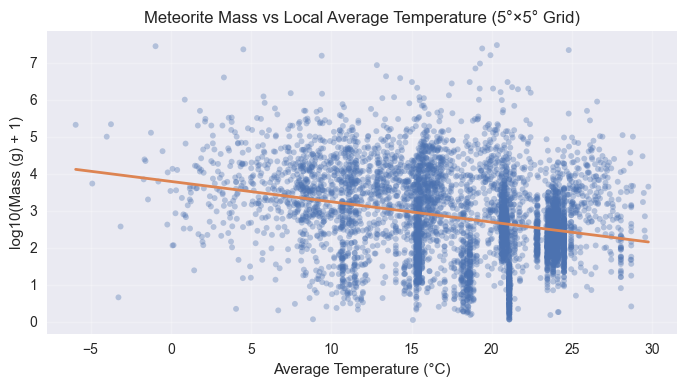

In [36]:
fig, ax = plt.subplots()

ax.scatter(
    meteor_temp_geo["avg_temp"],
    meteor_temp_geo["log_mass"],
    s=18, alpha=0.35,
    color=color_scatter,
    edgecolors="none"
)

z = np.polyfit(meteor_temp_geo["avg_temp"], meteor_temp_geo["log_mass"], 1)
x_line = np.linspace(meteor_temp_geo["avg_temp"].min(), meteor_temp_geo["avg_temp"].max(), 200)
y_line = np.polyval(z, x_line)
ax.plot(x_line, y_line, color=color_fit, linewidth=2)

ax.set_xlabel("Average Temperature (°C)")
ax.set_ylabel("log10(Mass (g) + 1)")
ax.set_title("Meteorite Mass vs Local Average Temperature (5°×5° Grid)")

plt.tight_layout()
plt.show()

### Number of meteorites by temperature range and average mass

In [37]:
# Set bins
bins = [-50, -10, 0, 10, 20, 30, 50]
labels = ['<-10', '-10~0', '0~10', '10~20', '20~30', '>30']

meteor_temp_geo['temp_bin'] = pd.cut(
    meteor_temp_geo['avg_temp'],
    bins=bins,
    labels=labels,
    right=False
)

temp_group_A = (
    meteor_temp_geo
    .groupby('temp_bin')
    .agg(
        count=('id', 'count'),
        avg_log_mass=('log_mass', 'mean')
    )
    .reset_index()
)

temp_group_A



C:\Users\15114\AppData\Local\Temp\ipykernel_29400\2676686358.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('temp_bin')


,temp_bin,count,avg_log_mass
0,<-10,0,NaN
1,-10~0,17,4.095237
2,0~10,618,3.554457
3,10~20,2225,2.929057
4,20~30,2515,2.504541
5,>30,0,NaN


### Bar charts on Number of meteorites in each temperature range and Average log mass per temperature interval

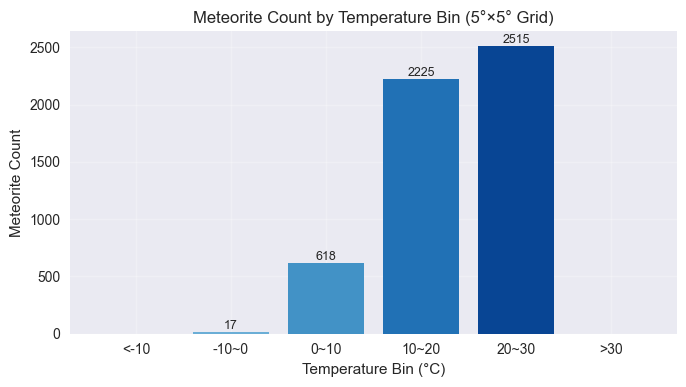

In [38]:
order_bins = ['<-10', '-10~0', '0~10', '10~20', '20~30', '>30']
temp_group_A_sorted = temp_group_A.set_index('temp_bin').reindex(order_bins).reset_index()

fig, ax = plt.subplots()

colors = (color_bars * ((len(order_bins) // len(color_bars)) + 1))[:len(order_bins)]

bars = ax.bar(
    temp_group_A_sorted['temp_bin'].astype(str),
    temp_group_A_sorted['count'],
    color=colors
)

ax.set_xlabel("Temperature Bin (°C)")
ax.set_ylabel("Meteorite Count")
ax.set_title("Meteorite Count by Temperature Bin (5°×5° Grid)")

for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center", va="bottom", fontsize=9
        )

plt.tight_layout()
plt.show()


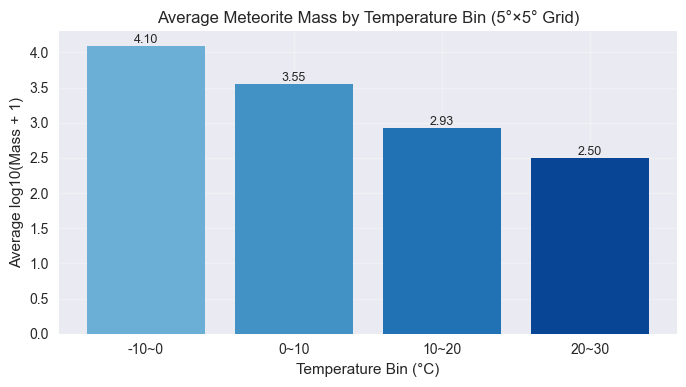

In [39]:
ffig, ax = plt.subplots()

bars = ax.bar(
    temp_group_A_sorted['temp_bin'].astype(str),
    temp_group_A_sorted['avg_log_mass'],
    color=colors
)

ax.set_xlabel("Temperature Bin (°C)")
ax.set_ylabel("Average log10(Mass + 1)")
ax.set_title("Average Meteorite Mass by Temperature Bin (5°×5° Grid)")

for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha="center", va="bottom", fontsize=9
        )

plt.tight_layout()
plt.show()

The main conclusions from this EDA are as follows: temperature does not appear to influence either the landing location or the mass of meteorites. The first scatter plot reveals a very weak negative correlation: one possible interpretation is that higher regional temperatures correlate with lower meteorite masses upon impact. However, this trend is not clearly discernible in the scatter plot.

## 2nd : How meteorite impacts temperature

In [40]:
meteor_geo = meteor_geo.loc[:, ~meteor_geo.columns.duplicated()].copy()

In [41]:
temp_grid_year = (
    temp_geo
    .groupby(['year', 'lat_bin', 'lon_bin'], as_index=False)
    .agg(avg_temp=('AverageTemperature', 'mean'))
)
meteor_grid_year = (
    meteor_geo
    .groupby(['year', 'lat_bin', 'lon_bin'], as_index=False)
    .agg(
        meteor_count=('id', 'count'),
        total_mass=('mass_g', 'sum')
    )
)
panel = temp_grid_year.merge(
    meteor_grid_year,
    on=['year', 'lat_bin', 'lon_bin'],
    how='left'
)

# Merge into a single panel
panel['meteor_count'] = panel['meteor_count'].fillna(0)
panel['total_mass'] = panel['total_mass'].fillna(0)

panel.head()

,year,lat_bin,lon_bin,avg_temp,meteor_count,total_mass
0,1743,30.0,-85.0,17.307000,0.0,0.0
1,1743,30.0,-80.0,17.145333,0.0,0.0
2,1743,35.0,-90.0,8.111667,0.0,0.0
3,1743,35.0,-85.0,8.943429,0.0,0.0
4,1743,35.0,-80.0,9.071333,0.0,0.0


#### Find temperature anomaly

In [42]:
year_mean = panel.groupby('year')['avg_temp'].transform('mean')
panel['temp_anomaly'] = panel['avg_temp'] - year_mean


#### Check relation Statisitcally

In [43]:
df = panel.copy()
X = df[['meteor_count']] 
X = sm.add_constant(X)
y = df['temp_anomaly']

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           temp_anomaly   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.929
Date:                Sun, 07 Dec 2025   Prob (F-statistic):              0.165
Time:                        14:25:10   Log-Likelihood:            -3.2015e+05
No. Observations:               88795   AIC:                         6.403e+05
Df Residuals:                   88793   BIC:                         6.403e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0014      0.030     -0.046   

#### Result: The coefficient for meteor_count is 0.0228, indicating that the correlation is not particularly strong.

## 3rd Question: Is there a correlation between temperature station density and the number of meteorite discoveries?

In [44]:
# Find city in each of 5* 5 grid
station_grid = (
    temp_geo
    .groupby(['lat_bin', 'lon_bin'], as_index=False)['City']
    .nunique()
    .rename(columns={'City': 'station_count'})
)

station_grid.head()


,lat_bin,lon_bin,station_count
0,-50.0,-70.0,1
1,-45.0,-70.0,1
2,-45.0,-65.0,1
3,-45.0,150.0,1
4,-45.0,170.0,2


#### Check how many meteor in each grid

In [45]:
meteor_grid = (
    meteor_geo
    .groupby(['lat_bin', 'lon_bin'], as_index=False)
    .agg(
        meteor_count=('id', 'count'),
        total_mass=('mass_g', 'sum')
    )
)

meteor_grid.head()

,lat_bin,lon_bin,meteor_count,total_mass
0,-85.0,-165.0,26,7310.9
1,-85.0,-150.0,9,6907.4
2,-85.0,-145.0,1,33.6
3,-85.0,-140.0,217,103470.7
4,-85.0,-125.0,33,12207.0


In [46]:
grid_merged = station_grid.merge(
    meteor_grid,
    on=['lat_bin', 'lon_bin'],
    how='outer'
)

grid_merged['meteor_count'] = grid_merged['meteor_count'].fillna(0)
grid_merged['total_mass']   = grid_merged['total_mass'].fillna(0)

grid_merged.head(), grid_merged.shape

(   lat_bin  lon_bin  station_count  meteor_count  total_mass
 0    -85.0   -165.0            NaN          26.0      7310.9
 1    -85.0   -150.0            NaN           9.0      6907.4
 2    -85.0   -145.0            NaN           1.0        33.6
 3    -85.0   -140.0            NaN         217.0    103470.7
 4    -85.0   -125.0            NaN          33.0     12207.0,
 (620, 5))

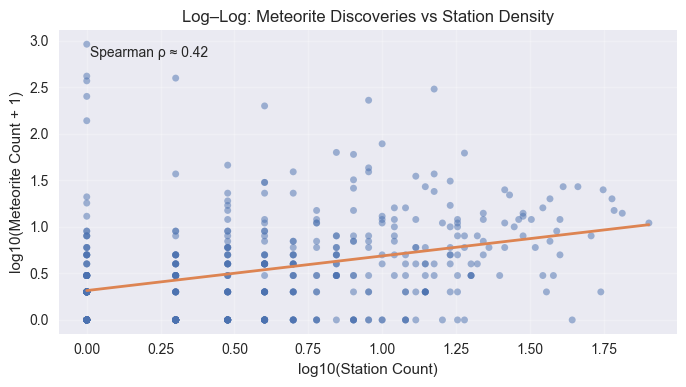

In [47]:
data = grid_merged[grid_merged['station_count'] > 0].copy()
data['log_station'] = np.log10(data['station_count'])
data['log_meteor']  = np.log10(data['meteor_count'] + 1)

fig, ax = plt.subplots()

ax.scatter(
    data['log_station'],
    data['log_meteor'],
    s=25, alpha=0.5,
    color=color_scatter,
    edgecolors="none"
)

z = np.polyfit(data['log_station'], data['log_meteor'], 1)
x_line = np.linspace(data['log_station'].min(), data['log_station'].max(), 200)
y_line = np.polyval(z, x_line)
ax.plot(x_line, y_line, color=color_fit, linewidth=2)

ax.set_xlabel("log10(Station Count)")
ax.set_ylabel("log10(Meteorite Count + 1)")
ax.set_title("Log–Log: Meteorite Discoveries vs Station Density")

import pandas as pd
spearman_corr = data['station_count'].corr(data['meteor_count'], method='spearman')
ax.text(
    0.05, 0.95,
    f"Spearman ρ ≈ {spearman_corr:.2f}",
    transform=ax.transAxes,
    ha="left", va="top", fontsize=10
)

plt.tight_layout()
plt.show()

In [48]:
pearson_corr = data['station_count'].corr(data['meteor_count'])
spearman_corr = data['station_count'].corr(data['meteor_count'], method='spearman')

pearson_corr, spearman_corr

(np.float64(-0.008510043220145556), np.float64(0.42088007283365225))

Result: the Pearson correlation between the number of temperature stations and meteorite discoveries approaches zero (-0.008), while the Spearman rank correlation is approximately 0.42. This indicates that, on the raw count scale, no clear linear relationship exists between the two variables. However, in terms of ranking significance, regions with more observation stations do indeed record more meteorites overall. This phenomenon aligns with the intuitive expectation that "higher observation density will lead greater likelihood of meteorite discovery," while also reflecting that meteorite detection is significantly influenced by other geographical and scientific factors.